In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras.regularizers import L1L2
###
import tensorflow.keras.utils as ku 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.callbacks import Callback

import numpy as np

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2021-01-21 01:15:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 172.217.5.240, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-21 01:15:12 (126 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [5]:
predictors.shape

(15462, 10)

In [7]:
# set hyperparameters
emb_dim = 150
num_epochs = 100
DO_rate = 0.05
LSTM1_unit = 128
LSTM2_unit = 128
Dense_unit = 2056
l1_param = 0.001
l2_param = 0.001
lr = 0.001
batch_size = 16

In [14]:
model = Sequential(name='week4_exercise_question_model')
model.add(Embedding(input_dim=total_words, output_dim=emb_dim, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(units=LSTM2_unit, return_sequences=True)))
model.add(Dropout(rate=DO_rate))
model.add(Bidirectional(LSTM(units=LSTM2_unit)))
model.add(Dense(units=Dense_unit, activation='relu', kernel_regularizer=L1L2(l1=l1_param, l2=l2_param)))
model.add(Dense(units=total_words, activation='softmax'))
# Pick an optimizer
model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
print(model.summary())

Model: "week4_exercise_question_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 150)           481650    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10, 256)           285696    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_4 (Dense)              (None, 2056)              528392    
_________________________________________________________________
dense_5 (Dense)              (None, 3211)              6605027   
Total params: 8,295,005
Trainable params: 8,295,005
Non-trainable params: 0
___________________________

In [15]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('precision_2') > 0.95 and logs.get('recall_2') > 0.95:
            print('Precision and Recall reached more than 95%. Training terminated.')
            self.model.stop_training = True

callback = myCallback()

In [16]:
history = model.fit(predictors, label, epochs=num_epochs, verbose=1, batch_size=batch_size, callbacks=[callback])

Epoch 1/100
967/967 [==============================] - 19s 14ms/step - loss: 8.4466 - accuracy: 0.0192 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2/100
967/967 [==============================] - 14s 14ms/step - loss: 6.5647 - accuracy: 0.0225 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 3/100
967/967 [==============================] - 14s 14ms/step - loss: 6.4486 - accuracy: 0.0278 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 4/100
967/967 [==============================] - 14s 14ms/step - loss: 6.3169 - accuracy: 0.0379 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 5/100
967/967 [==============================] - 14s 14ms/step - loss: 6.1987 - accuracy: 0.0390 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 6/100
967/967 [==============================] - 14s 14ms/step - loss: 6.0479 - accuracy: 0.0416 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 7/100
967/967 [==============================] - 14s 15ms/step - loss: 5.9352 - ac

In [17]:
# another 50 epochs
history = model.fit(predictors, label, epochs=50, verbose=1, batch_size=batch_size, callbacks=[callback])

Epoch 1/50
967/967 [==============================] - 14s 14ms/step - loss: 1.0998 - accuracy: 0.8229 - precision_2: 0.9669 - recall_2: 0.7696
Epoch 2/50
967/967 [==============================] - 14s 14ms/step - loss: 1.1017 - accuracy: 0.8220 - precision_2: 0.9651 - recall_2: 0.7674
Epoch 3/50
967/967 [==============================] - 14s 14ms/step - loss: 1.0960 - accuracy: 0.8223 - precision_2: 0.9619 - recall_2: 0.7670
Epoch 4/50
967/967 [==============================] - 14s 14ms/step - loss: 1.0790 - accuracy: 0.8267 - precision_2: 0.9677 - recall_2: 0.7719
Epoch 5/50
967/967 [==============================] - 14s 14ms/step - loss: 1.0854 - accuracy: 0.8247 - precision_2: 0.9661 - recall_2: 0.7698
Epoch 6/50
967/967 [==============================] - 14s 14ms/step - loss: 1.0656 - accuracy: 0.8256 - precision_2: 0.9665 - recall_2: 0.7754
Epoch 7/50
967/967 [==============================] - 14s 14ms/step - loss: 1.0642 - accuracy: 0.8263 - precision_2: 0.9675 - recall_2: 0.7755

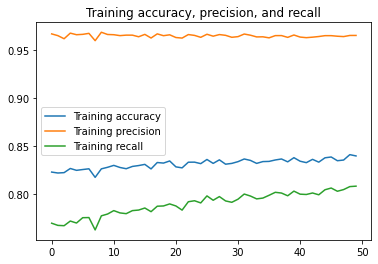

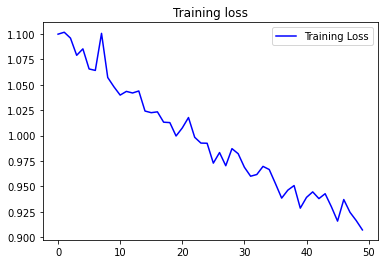

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
precision = history.history['precision_2']
recall = history.history['recall_2']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, precision, label='Training precision')
plt.plot(epochs, recall, label='Training recall')
plt.title('Training accuracy, precision, and recall')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [20]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope doth spend behind me white hearts rare indigest hill curious days much given could die not honour thought deep sunken thought do silent heart and pride all both date pride days outworn his shore vanish'd time hour doom and friend acquainted masonry eyed wantonly grossly thee keep an music tell happy night in light cross'd earthly cause and make thy side grown now water prepare the faces which sang foil'd stronger meet hot deceive reap altering an gently store leaves interchange words happy sea a dispatch ocean new worth are still me so bright worth their glory be best show'st
